In [43]:
import numpy as np
import copy
from astropy.coordinates import Angle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pyuvdata import UVData
import pyuvdata.utils as uvutils

In [2]:
file1 = '/data4/beards/phasing_test_data/1133866760.uvfits'
file2 = '/data4/beards/phasing_test_data/1133866760_rephase.uvfits'
f1_phase_center_ra = Angle('01h39m00.0s')
f1_phase_center_dec = Angle('-17d57m00s')
f2_phase_center_ra = Angle('00h00m00.0s')
f2_phase_center_dec = Angle('-18d00m00s')

In [3]:
uvd1 = UVData()
uvd2 = UVData()
uvd1.read_uvfits(file1)
uvd2.read_uvfits(file2)

In [4]:
uvd1_drift = copy.deepcopy(uvd1)
uvd1_drift.unphase_to_drift()
uvd2_drift = copy.deepcopy(uvd2)
uvd2_drift.unphase_to_drift()

In [5]:
print(uvd1.phase_center_ra, uvd1.phase_center_dec, uvd1.phase_center_epoch)
print(f1_phase_center_ra.rad, f1_phase_center_dec.rad)

(0.4319689898685966, -0.31328660073298215, 2000.0)
(0.4319689898685965, -0.31328660073298215)


In [6]:
uvd2_rephase = copy.deepcopy(uvd2_drift)
uvd2_rephase.phase(uvd1.phase_center_ra,
                 uvd1.phase_center_dec,
                 uvd1.phase_center_epoch)

In [7]:
data_diff = uvd1.data_array - uvd2_rephase.data_array
print(np.max(np.abs(data_diff)))

1482.4666


In [8]:
uvw_diff = uvd1.uvw_array - uvd2_rephase.uvw_array
print(np.max(np.abs(uvw_diff)))

1.7875977


In [9]:
data_diff = uvd1_drift.data_array - uvd2_drift.data_array
print(np.max(np.abs(data_diff)))

1.2953553


In [10]:
uvw_diff = uvd1_drift.uvw_array - uvd2_drift.uvw_array
print(np.max(np.abs(uvw_diff)))

1.7779541


In [25]:
def uvw_from_pos(uv_obj):
    if uv_obj.phase_type != 'drift':
        raise ValueError('uvw_from_pos can only be calculated for drift observations')
    
    antpos_ECEF = uv_obj.antenna_positions + uv_obj.telescope_location
    ant_pos_ENU = uvutils.ENU_from_ECEF(antpos_ECEF.T, *uv_obj.telescope_location_lat_lon_alt).T
    
    uvw_array = np.zeros_like(uv_obj.uvw_array)
    unique_bls, unique_inds = np.unique(uv_obj.baseline_array, return_index=True)
    for ind, bl in enumerate(unique_bls):
        inds = np.where(uv_obj.baseline_array == bl)[0]
        
        ant1_pos = ant_pos_ENU[uv_obj.ant_1_array[unique_inds[ind]]]
        ant2_pos = ant_pos_ENU[uv_obj.ant_2_array[unique_inds[ind]]]
        this_uvw = ant2_pos - ant1_pos
        
        uvw_array[inds, :] = this_uvw
    
    return uvw_array

In [30]:
ant_pos_diff = uvd1_drift.antenna_positions - uvd2_drift.antenna_positions
print(np.max(np.abs(ant_pos_diff)))

0.0


In [51]:
uvw_calc = uvw_from_pos(uvd1_drift)
uvw_diff_calc1 = uvd1_drift.uvw_array - uvw_calc
uvw_diff_calc2 = uvd2_drift.uvw_array - uvw_calc


In [52]:
print(np.max(np.abs(uvw_diff_calc1)))
print(np.max(np.abs(uvw_diff_calc2)))

1.9038696
0.12780762


In [11]:
uvw_diff.shape

(311640, 3)

In [37]:
np.linalg.norm(uvw_diff_calc1, axis=1).shape

(311640,)

In [53]:
def plot_uvw_diff(ref_array, diff_array, ref_label, diff_label):

    matplotlib.rcParams['figure.figsize'] = (20,20)

    plt.figure(1)
    fig, axes = plt.subplots(2, 2)
    axes[0, 0].scatter(ref_array[:,0], diff_array[:, 0],
                 s=0.25, marker="o")
    axes[0, 0].set_xlabel("u" + ref_label)
    axes[0, 0].set_ylabel("du (" + diff_label + ")")
    axes[0, 0].set_title("drift u: " + diff_label)

    axes[0, 1].scatter(ref_array[:,1], diff_array[:, 1],
                 s=0.25, marker="o")
    axes[0, 1].set_xlabel("v" + ref_label)
    axes[0, 1].set_ylabel("dv (" + diff_label + ")")
    axes[0, 1].set_title("drift v: " + diff_label)

    axes[1, 0].scatter(ref_array[:,2], diff_array[:, 2],
                 s=0.25, marker="o")
    axes[1, 0].set_xlabel("w" + ref_label)
    axes[1, 0].set_ylabel("dw (" + diff_label + ")")
    axes[1, 0].set_title("drift w: " + diff_label)

    axes[1, 1].scatter(np.linalg.norm(ref_array, axis=1),
                    np.linalg.norm(diff_array, axis=1),
                    s=0.25, marker="o")
    axes[1, 1].set_xlabel("|u" + ref_label + "|")
    axes[1, 1].set_ylabel("|du| | (" + diff_label + ")|")
    axes[1, 1].set_title("drift |u|: " + diff_label)
    
    fig.show()

<Figure size 1440x1440 with 0 Axes>

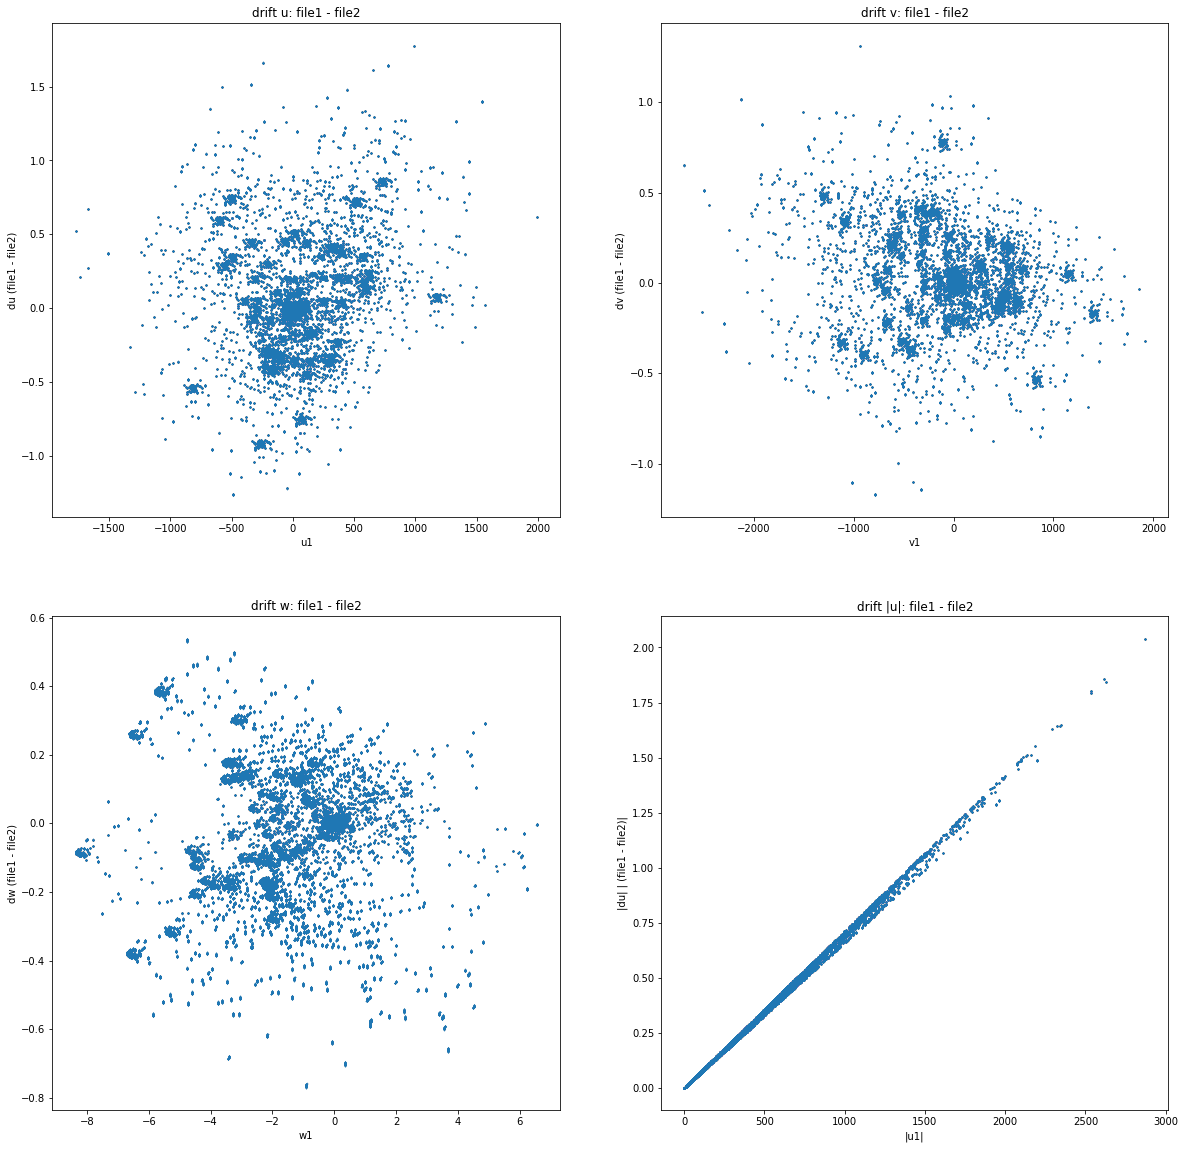

In [54]:
plot_uvw_diff(uvd1_drift.uvw_array, uvw_diff, '1', 'file1 - file2')

<Figure size 1440x1440 with 0 Axes>

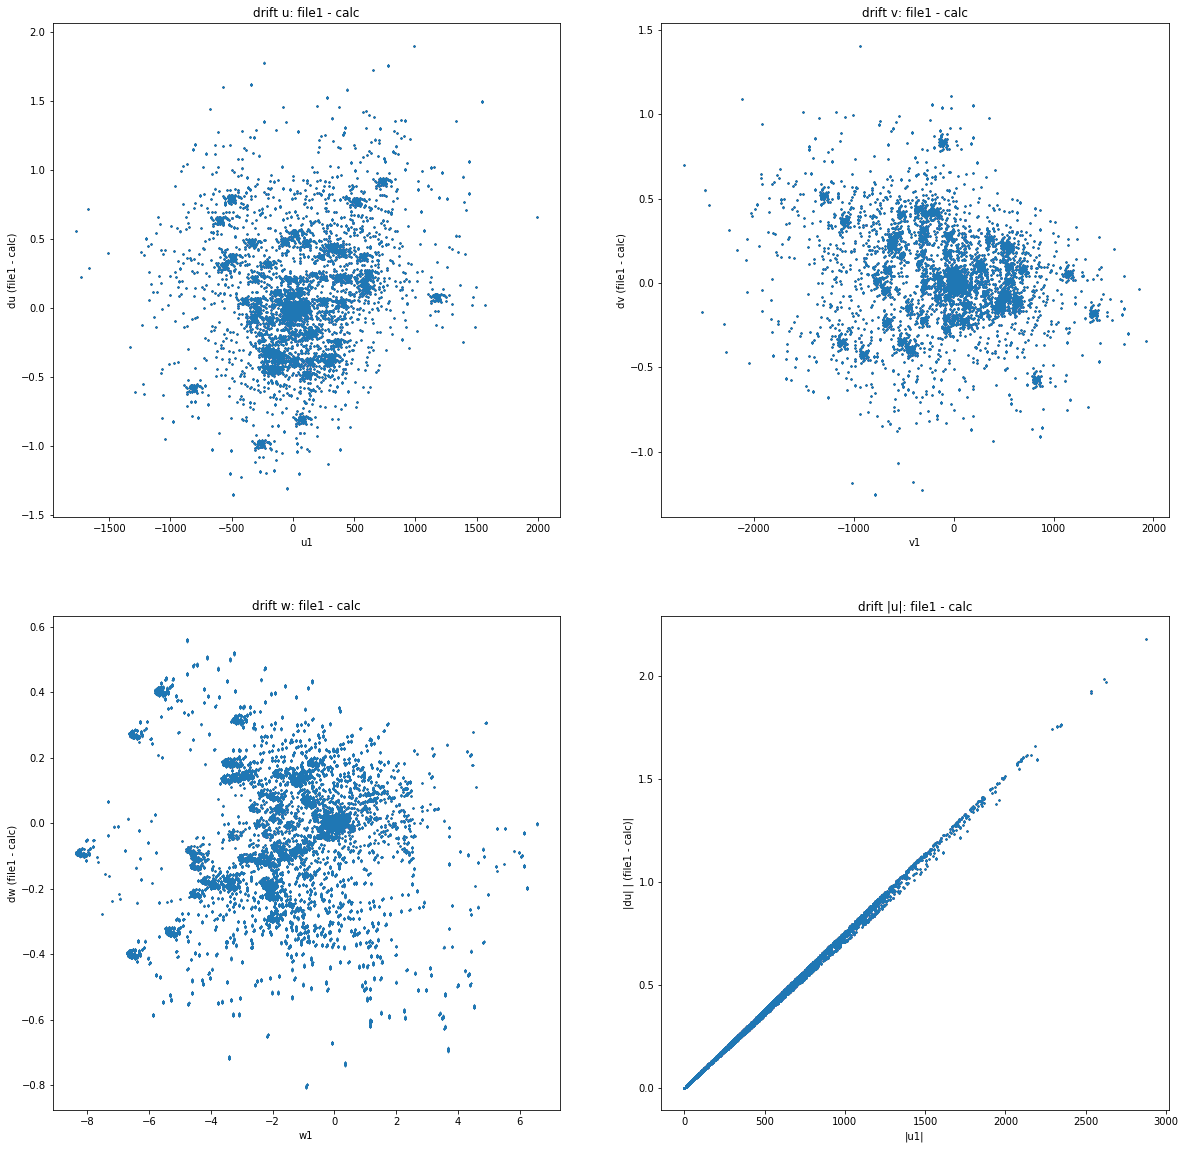

In [55]:
plot_uvw_diff(uvd1_drift.uvw_array, uvw_diff_calc1, '1', 'file1 - calc')

<Figure size 1440x1440 with 0 Axes>

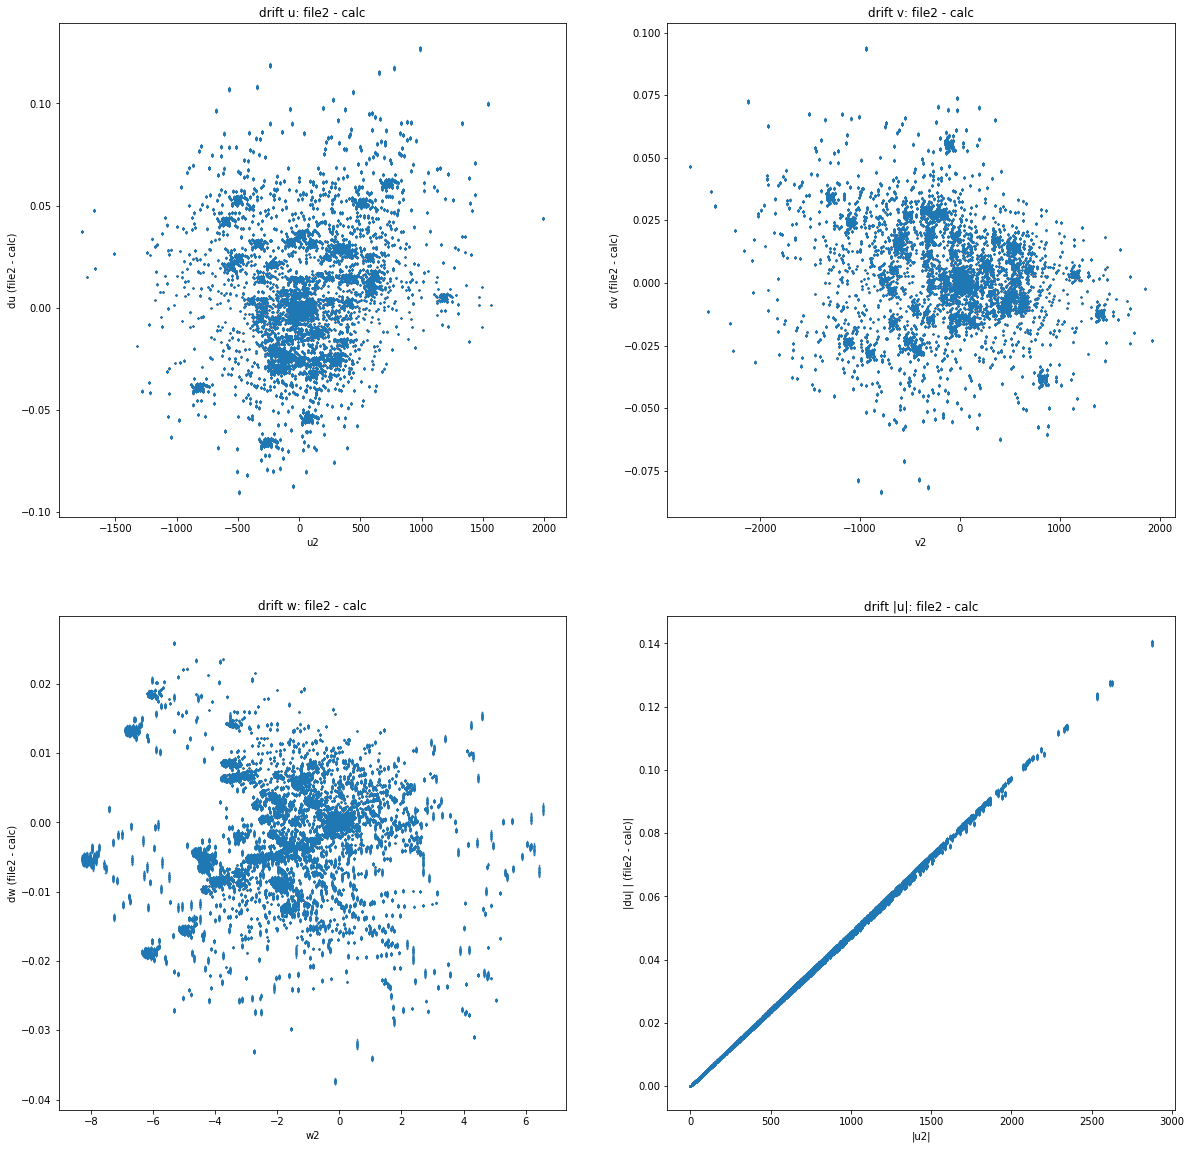

In [56]:
plot_uvw_diff(uvd2_drift.uvw_array, uvw_diff_calc2, '2', 'file2 - calc')